Import libraries

In [3]:
from helpers import load_csv_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

Load data

In [12]:
data_path='data/dataset/dataset'
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

print("Number of samples of train: ", x_train.shape[0])
print("Number of features: ", x_train.shape[1])
print("Number of samples of test: ", x_test.shape[0])
print("Data type x_train:", x_train.dtype) #float64
print("Data type y_train:", y_train.dtype) #int64

Number of samples of train:  328135
Number of features:  321
Number of samples of test:  109379
Data type x_train: float64
Data type y_train: int64


Data cleaning from invalid values and NaN

In [ ]:
### OPTIONAL CELL:
### Try to see if adding this improves performance 
### DOESN'T CONVINCE ME THAT 7 CAN BE NON VALID OR VALID DEPENDING ON THE COLUMN / WHETHER FEATURE
### IS CATEGORICAL OR CONTINUOUS, IF I ALWAYS REPLACE IT WITH MEAN E.G. WE CAN SMOOTH DATA TOO MUCH

# Non valid values to replace
invalid_values = {7, 9, 14, 77, 88, 99}

# Function to replace non valid values with NaN
def replace_invalids(arr, invalids):
    # Copia per non modificare in place (opzionale)
    arr_clean = arr.copy().astype(float)  # assicurati tipo float per NaN
    for invalid in invalids:
        arr_clean[arr_clean == invalid] = np.nan
    return arr_clean

# Call the function
x_train_new_clean = replace_invalids(x_train, invalid_values)

In [ ]:
missing_counts = np.sum(np.isnan(x_train), axis=0)
missing_percents = missing_counts / x_train.shape[0] * 100

print(f"Number of features with more than 40% of NaN: {np.sum(missing_percents>40)}")

# Drop feature if at least 40% are NaN values
valid_cols_nan = np.where(np.isnan(x_train).sum(axis=0) < 0.4 * x_train.shape[0])[0]
x_train_clean = x_train[:, valid_cols_nan]
print(x_train_clean.shape)

# For other columns, NaN are replaced with the mean
col_mean = np.nanmean(x_train_clean, axis = 0)  # np.nanmean ignores the NaN
inds =np.where(np.isnan(x_train_clean))
x_train_clean[inds] = col_mean[inds[1]]        #x_train_clean[inds] = np.take(col_mean, inds[1])

Number of features with more than 40% of NaN: 158
(328135, 163)


Data cleaning: highly correlated features

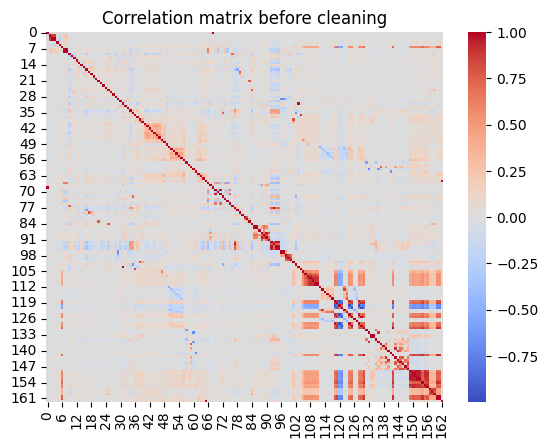

New shape: (328135, 128)


In [14]:
# Cross-correlation among features
def corrcoef(X):
    n_features = X.shape[1]
    corr = np.empty((n_features, n_features))
    for i in range(n_features):
        for j in range(i, n_features):
            corr_ij = np.corrcoef(X[:, i], X[:, j])[0, 1]       # np.corrcoef returns correlation matrix of two 1D-arrays, corr_ij is in position [0,1]            
            corr[i, j] = corr_ij
            corr[j, i] = corr_ij  
    return corr

corr_matrix = corrcoef(x_train_clean)
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation matrix before cleaning')
plt.show()

# Drop features if correlation > 0.9

non_valid_col = set()  # Use set to avoid duplicates
for i in range(x_train_clean.shape[1]):
    for j in range(i + 1, x_train_clean.shape[1]):
        if abs(corr_matrix[i, j]) > 0.9:
            non_valid_col.add(j)  # Drop j, keep i

x_train_new = np.delete(x_train_clean, list(non_valid_col), axis=1)     # Remove column
print(f"New shape: {x_train_new.shape}")

Soglia fissa impostata a 20 valori unici


Totale feature categoriche (<= 20 unique): 81
Totale feature continue    (>  20 unique): 47


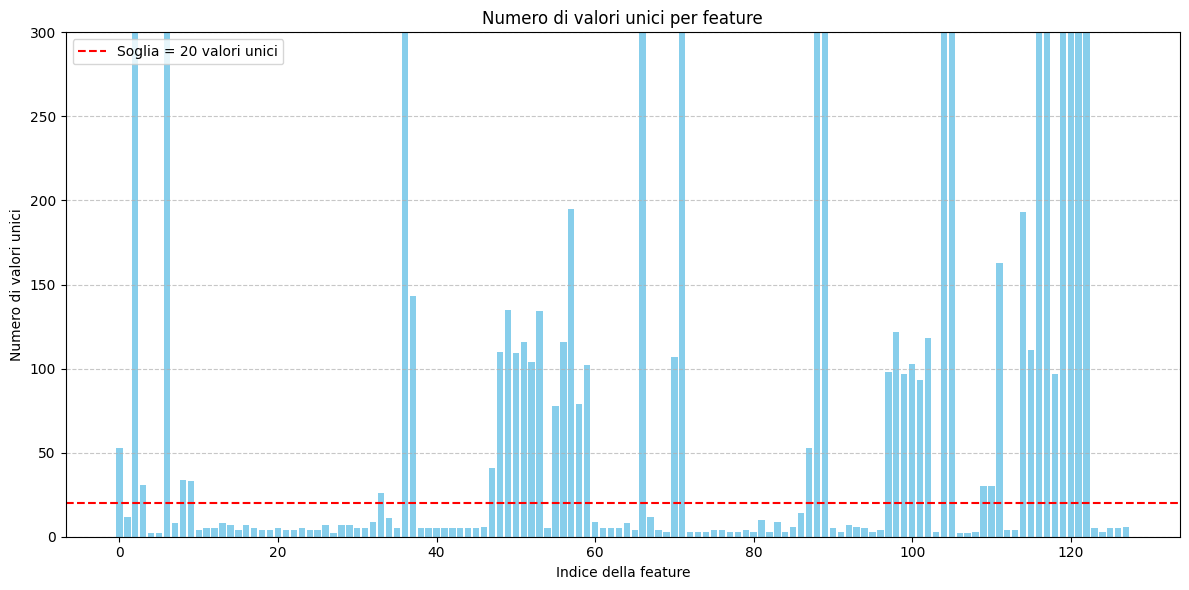

In [17]:
# Soglia fissa: se una feature ha <= 20 valori unici → categorizzata come categorica
threshold = 20
print(f"Soglia fissa impostata a {threshold} valori unici\n")

categorical_features = []
continuous_features = []
unique_counts = []

for i in range(x_train_new.shape[1]):
    col = x_train_new[:, i]
    count = len(np.unique(col))
    unique_counts.append(count)

    if count <= threshold:
        categorical_features.append(i)
        label = 'CATEGORICA'
    else:
        continuous_features.append(i)
        label = 'CONTINUA'

    # Debug (opzionale):
    # print(f"Feature {i:2}: {count:5} valori unici → {label}")

# Riepilogo
print(f"\nTotale feature categoriche (<= {threshold} unique): {len(categorical_features)}")
print(f"Totale feature continue    (>  {threshold} unique): {len(continuous_features)}")

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(unique_counts)), unique_counts, color='skyblue')
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Soglia = {threshold} valori unici')
plt.xlabel('Indice della feature')
plt.ylabel('Numero di valori unici')
plt.ylim(top=300)
plt.title('Numero di valori unici per feature')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Z-score normalization

In [10]:
col_mean_0=np.mean(x_train_clean, axis=0)
col_sd_0=np.std(x_train_clean, axis=0)

x_train_norm=(x_train_clean-col_mean_0)/col_sd_0

col_mean=np.mean(x_train_norm, axis=0)
col_sd=np.std(x_train_norm, axis=0)
print(f"Before normalization, mean: {col_mean_0[0:5]}, sd: {col_sd_0[0:5]}")
print(f"After normalization, mean: {col_mean[0:5]}, sd: {col_sd[0:5]}")



Before normalization, mean: [2.99736511e+01 6.36068996e+00 6.56363820e+06 6.41666083e+00
 1.44962348e+01], sd: [1.60317529e+01 3.48725721e+00 3.48924235e+06 3.49273367e+00
 8.33448235e+00]
After normalization, mean: [-9.84389741e-17  5.97379058e-18 -6.97799371e-18 -8.38279539e-17
 -9.75511611e-17], sd: [1. 1. 1. 1. 1.]


Classes distribution

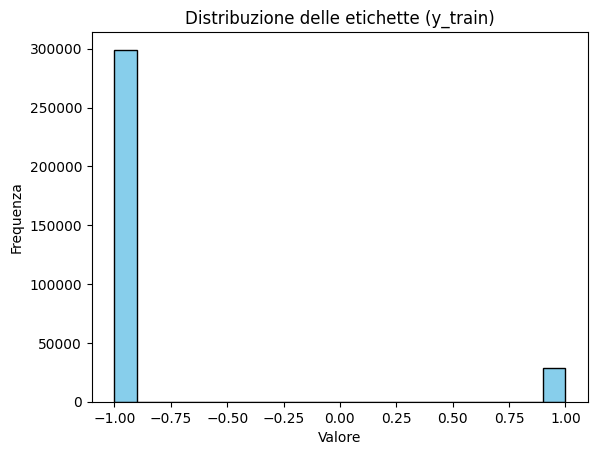

In [11]:
plt.hist(y_train, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribuzione delle etichette (y_train)")
plt.xlabel("Valore")
plt.ylabel("Frequenza")
plt.show()